In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
cd '/content/drive/MyDrive/ElNiño'

/content/drive/MyDrive/ElNiño


In [60]:
!pip install cartopy
!pip install geoviews

In [61]:
# imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import os
import pooch
import tempfile
import holoviews
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from geoviews import Dataset as gvDataset
import geoviews.feature as gf
from geoviews import Image as gvImage

In [62]:
# download the monthly sea surface temperature data from NOAA Physical System
# Laboratory. The data is processed using the OISST SST Climate Data Records
# from the NOAA CDR program.
# the data downloading may take 2-3 minutes to complete.
# filename=sst.mon.mean.nc
# url_sst = "https://osf.io/6pgc2/download/"
filename = "sst.mon.mean.nc"

# we divide the data into small chunks to allow for easier memory manangement. this is all done automatically, no need for you to do anything
ds = xr.open_dataset(filename)
ds

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 499, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1981-09-01 1981-10-01 ... 2023-03-01
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 2GB ...
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

In [63]:
# get 30-year climatology from 1982-2011
sst_30yr = ds.sst.sel(time=slice("1982-01-01", "2011-12-01"))

# calculate monthly climatology
sst_clim = sst_30yr.groupby("time.month").mean()
sst_clim

<xarray.DataArray 'sst' (month: 12, lat: 720, lon: 1440)> Size: 50MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.7287635, -1.7287527, -1.7286991, ..., -1.7289138,
         -1.7288492, -1.7288171],
        [-1.7309034, -1.7308818, -1.7308711, ..., -1.7310214,
         -1.7309357, -1.7309357],
        [-1.7318065, -1.7318065, -1.7318065, ..., -1.7318172,
         -1.7318172, -1.7318065]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [-1.6975776, -1.6975553, -1.6975553, ..., -1.6976665,
         -1.6976444, -1.697611 ],
        [-1.6984556, -1.6984445, -1.6984445, ..., -1.698489 ,
         -1.698489 , -1.6984779],
        [-1.6989446, -1.6989446, -1.6989446, ..., -1.6989557,
         -1.6989446, -1.6989446]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.7280643, -1.7280537, -1.7279783, ..., -1.7281611,
         -1.728129 , -1.728086 ],
        [-1.7293116, -1.7292687, -1.7292794, ..., -1.7293333,
         -1.7293332, -1.7293332],
        [-1.7297848, -1.7297848, -1.7297741, ..., -1.7297956,
         -1.7297956, -1.7297956]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:      Monthly Mean of Sea Surface Temperature
    units:          degC
    valid_range:    [-3. 45.]
    precision:      2.0
    dataset:        NOAA High-resolution Blended Analysis
    var_desc:       Sea Surface Temperature
    level_desc:     Surface
    statistic:      Monthly Mean
    parent_stat:    Individual Observations
    actual_range:   [-1.8  32.14]
    standard_name:  sea_surface_temperature

In [64]:
# calculate monthly anomaly
sst_anom = ds.sst.groupby("time.month") - sst_clim
sst_anom

<xarray.DataArray 'sst' (time: 499, lat: 720, lon: 1440)> Size: 2GB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.01085567, -0.01088893, -0.01158917, ..., -0.01072216,
         -0.01075542, -0.0104444 ],
        [-0.01407778, -0.01444435, -0.01443326, ..., -0.01364458,
         -0.01367784, -0.01403344],
        [-0.01648879, -0.01648879, -0.01648879, ..., -0.01645553,
         -0.01646662, -0.01647782]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.00019252, -0.01161695, -0.01914048, ..., -0.02573752,
         -0.01934457, -0.00403416],
        [-0.00681448, -0.0332433 , -0.04361224, ..., -0.0489099 ,
         -0.0392909 , -0.01251709],
        [-0.06280601, -0.06280601, -0.06280601, ..., -0.06280601,
         -0.06280601, -0.06280601]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.00821507, -0.00633335, -0.01377428, ..., -0.02069879,
         -0.01104295,  0.00568819],
        [ 0.00094604, -0.02874207, -0.03938723, ..., -0.03993535,
         -0.02898932,  0.0009892 ],
        [-0.05611825, -0.05611825, -0.05612886, ..., -0.0561074 ,
         -0.0561074 , -0.0561074 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1981-09-01 1981-10-01 ... 2023-03-01
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
    month    (time) int64 4kB 9 10 11 12 1 2 3 4 5 6 ... 6 7 8 9 10 11 12 1 2 3

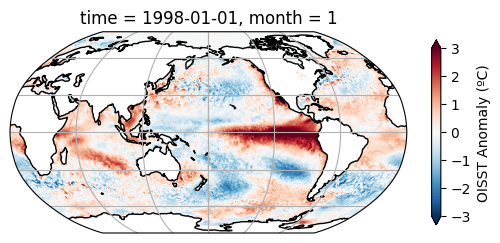

In [65]:
sst = sst_anom.sel(time="1998-01-01")

# initiate plot
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.Robinson(central_longitude=180)},
    #figsize=(9, 6)
)

# focus on the ocean with the central_longitude=180
ax.coastlines()
ax.gridlines()
sst.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    vmin=-3,
    vmax=3,
    cmap="RdBu_r",
    cbar_kwargs=dict(shrink=0.5, label="OISST Anomaly (ºC)"),
)

In [66]:
# extract SST data from the Niño 3.4 region
sst_nino = sst_anom.sel(lat=slice(-5, 5), lon=slice(190, 240))
sst_nino

# if we want to analyze stuff happening in the coast of Peru, it might be better
# to use the Niño 1+2 region. In that case, use
# sst_nino = sst_anom.sel(lat=slice(-10, 0), lon=slice(80, 90))
# sst_nino

<xarray.DataArray 'sst' (time: 499, lat: 40, lon: 200)> Size: 16MB
array([[[-6.69525146e-01, -6.80366516e-01, -6.93876266e-01, ...,
          2.76653290e-01,  2.96335220e-01,  3.01664352e-01],
        [-6.83284760e-01, -7.06535339e-01, -6.82203293e-01, ...,
          3.08546066e-01,  3.20869446e-01,  3.17598343e-01],
        [-7.16913223e-01, -7.02375412e-01, -6.67095184e-01, ...,
          3.28367233e-01,  3.47665787e-01,  3.56067657e-01],
        ...,
        [-2.94645309e-01, -2.72735596e-01, -2.93779373e-01, ...,
          3.79093170e-01,  4.22355652e-01,  3.72625351e-01],
        [-3.81984711e-01, -2.99722672e-01, -2.78633118e-01, ...,
          4.87499237e-01,  4.94678497e-01,  4.14009094e-01],
        [-4.47055817e-01, -3.37280273e-01, -2.42832184e-01, ...,
          4.76043701e-01,  4.41780090e-01,  3.42708588e-01]],

       [[-5.48688889e-01, -4.62980270e-01, -4.14043427e-01, ...,
         -1.21023178e-01, -7.19280243e-02, -3.16982269e-02],
        [-5.57636261e-01, -4.85677719e-01, -4.24419403e-01, ...,
         -1.35051727e-01, -9.95388031e-02, -8.07533264e-02],
        [-5.09346008e-01, -4.74029541e-01, -4.20312881e-01, ...,
         -1.26333237e-01, -1.30105972e-01, -1.29806519e-01],
...
         -6.95724487e-02, -8.14132690e-02, -9.69467163e-02],
        [-1.11291885e-01, -1.01837158e-01, -8.91838074e-02, ...,
         -6.76612854e-02, -6.63089752e-02, -7.35282898e-02],
        [-3.26271057e-02, -2.59494781e-02, -1.38664246e-02, ...,
         -9.23175812e-02, -8.33759308e-02, -7.82756805e-02]],

       [[-1.97212219e-01, -2.21448898e-01, -2.37428665e-01, ...,
          4.06059265e-01,  4.29023743e-01,  4.36105728e-01],
        [-2.03422546e-01, -2.19320297e-01, -2.30052948e-01, ...,
          4.61603165e-01,  4.77806091e-01,  4.79442596e-01],
        [-2.02465057e-01, -2.01200485e-01, -2.02280045e-01, ...,
          5.09149551e-01,  5.22302628e-01,  5.18348694e-01],
        ...,
        [ 3.83634567e-01,  3.89268875e-01,  3.86335373e-01, ...,
          4.00333405e-02,  4.61101532e-02,  6.12697601e-02],
        [ 3.96579742e-01,  4.01939392e-01,  3.97485733e-01, ...,
          1.56135559e-02,  2.57549286e-02,  4.84733582e-02],
        [ 3.84754181e-01,  3.85297775e-01,  3.85581970e-01, ...,
          7.38334656e-03,  2.79140472e-02,  5.29689789e-02]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1981-09-01 1981-10-01 ... 2023-03-01
  * lat      (lat) float32 160B -4.875 -4.625 -4.375 ... 4.375 4.625 4.875
  * lon      (lon) float32 800B 190.1 190.4 190.6 190.9 ... 239.4 239.6 239.9
    month    (time) int64 4kB 9 10 11 12 1 2 3 4 5 6 ... 6 7 8 9 10 11 12 1 2 3

In [67]:
# calculate the mean values for the Nino 3.4 region
nino = sst_nino.mean(dim=["lat", "lon"])

In [68]:
nino.to_netcdf('nino_timeseries.nc')
nino_ds = xr.open_dataset('nino_timeseries.nc')
nino = nino_ds.sst

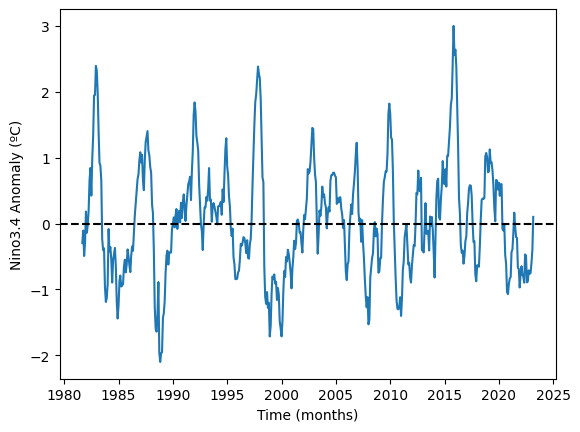

In [69]:
# plot time series for Nino 3.4 mean anomaly
fig, ax = plt.subplots()
nino.plot(ax=ax)
# aesthetics
ax.set_xlabel("Time (months)")
ax.set_ylabel("Nino3.4 Anomaly (ºC)")
ax.axhline(y=0, color="k", linestyle="dashed")

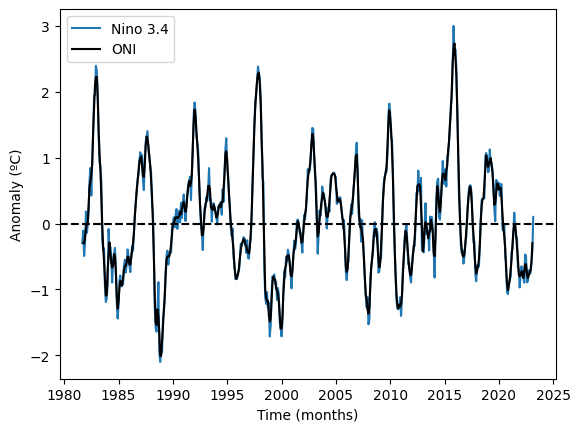

In [70]:
# calculate 3-month rolling mean of Nino 3.4 anomaly for the ONI
oni = nino.rolling(time=3, center=True).mean()

# generate time series plot
fig, ax = plt.subplots()
nino.plot(label="Nino 3.4", ax=ax)
oni.plot(color="k", label="ONI", ax=ax)
# aesthetics
ax.set_xlabel("Time (months)")
ax.set_ylabel("Anomaly (ºC)")
ax.axhline(y=0, color="k", linestyle="dashed")
ax.legend()

Text(0, 0.5, 'ONI')

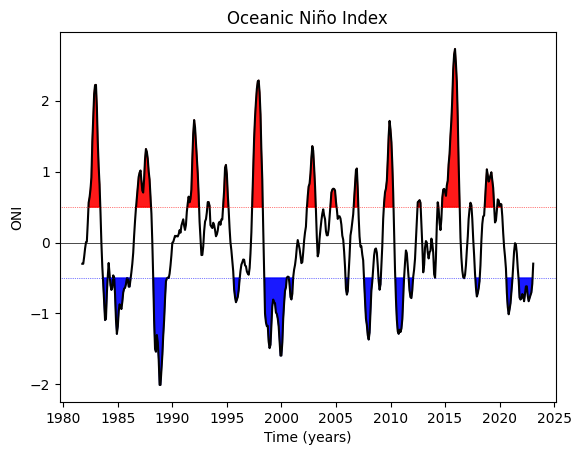

In [71]:
# set up the plot size
fig, ax = plt.subplots()

# create the filled area when ONI values are above 0.5 for El Nino
ax.fill_between(
    oni.time.data,
    oni.where(oni >= 0.5).data,
    0.5,
    color="red",
    alpha=0.9,
)

# create the filled area when ONI values are below -0.5 for La Nina
ax.fill_between(
    oni.time.data,
    oni.where(oni <= -0.5).data,
    -0.5,
    color="blue",
    alpha=0.9,
)

# create the time series of ONI
oni.plot(color="black", ax=ax)

# add the threshold lines on the plot
ax.axhline(0, color="black", lw=0.5)
ax.axhline(0.5, color="red", linewidth=0.5, linestyle="dotted")
ax.axhline(-0.5, color="blue", linewidth=0.5, linestyle="dotted")
# aesthetics
ax.set_title("Oceanic Niño Index")
ax.set_xlabel('Time (years)')
ax.set_ylabel('ONI')

In [72]:
df = oni.to_dataframe()

df

,month,sst
time,,
1981-09-01,9,NaN
1981-10-01,10,-0.299151
1981-11-01,11,-0.299240
1981-12-01,12,-0.202915
1982-01-01,1,-0.085143
...,...,...
2022-11-01,11,-0.741899
2022-12-01,12,-0.704129
2023-01-01,1,-0.581485


In [73]:
# Save the file
df.to_csv('/content/drive/My Drive/ElNiño/ONI_data.csv', index=True)

# If necessary, load the data
# df = pd.read_csv('/content/drive/My Drive/ElNiño/ONI_data.csv')

# Create interactive plots

In [74]:
fig = px.line(x=df.index, y=df['sst'])
# Update layout
fig.update_layout(
    title="ONI Fluctuations",
    xaxis_title="Time",
    yaxis_title="ONI",
)
fig.show()

Let us define El Niño, Neutral and La Niña phenomena according to the following coditions:

- El Niño $\rightarrow y\ge0.5$
- Neutral $\rightarrow -0.5\lt y\gt0.5$
- La Niña $\rightarrow y\le-0.5$

In [75]:
df['ElNiño'] = df['sst'].where(df['sst'] >= 0.5)  # El Niño: ONI >= 0.5
df['LaNiña'] = df['sst'].where(df['sst'] <= -0.5) # La Niña: ONI <= -0.5
df['Neutral'] = df['sst'].where((df['sst'] > -0.5) & (df['sst'] < 0.5))  # Neutral: -0.5 < ONI < 0.5

In [76]:
# Create the figure
fig = go.Figure()

# Add El Niño sections (ONI >= 0.5) in red
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['ElNiño'],
    mode='lines',
    line=dict(color='red'),
    name='El Niño (ONI >= 0.5)'
))

# Add La Niña sections (ONI <= -0.5) in blue
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['LaNiña'],
    mode='lines',
    line=dict(color='blue'),
    name='La Niña (ONI <= -0.5)'
))

# Add Neutral sections (-0.5 < ONI < 0.5) in gray
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Neutral'],
    mode='lines',
    line=dict(color='gray'),
    name='Neutral (-0.5 < ONI < 0.5)'
))

# Add horizontal lines for thresholds
fig.add_hline(y=0.5, line_dash="dash", line_color="red", annotation_text="El Niño Threshold")
fig.add_hline(y=-0.5, line_dash="dash", line_color="blue", annotation_text="La Niña Threshold")

# Update layout
fig.update_layout(
    title="ONI Classification",
    xaxis_title="Time",
    yaxis_title="ONI",
    legend_title="Classification",
    template="plotly_white"
)

# Show plot
fig.show()

In [77]:
df

,month,sst,ElNiño,LaNiña,Neutral
time,,,,,
1981-09-01,9,NaN,NaN,NaN,NaN
1981-10-01,10,-0.299151,NaN,NaN,-0.299151
1981-11-01,11,-0.299240,NaN,NaN,-0.299240
1981-12-01,12,-0.202915,NaN,NaN,-0.202915
1982-01-01,1,-0.085143,NaN,NaN,-0.085143
...,...,...,...,...,...
2022-11-01,11,-0.741899,NaN,-0.741899,NaN
2022-12-01,12,-0.704129,NaN,-0.704129,NaN
2023-01-01,1,-0.581485,NaN,-0.581485,NaN


In [78]:
df.to_csv('/content/drive/My Drive/ElNiño/ONI_data.csv', index=True)